In [180]:
import nibabel as nib #pip install nibabel
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import os.path as op
# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm
import os
from scipy.stats import zscore
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_stat_map
from sklearn.decomposition import PCA, FastICA

%matplotlib inline

https://openneuro.org/datasets/ds002322/versions/1.0.4  (alice)

https://openneuro.org/datasets/ds002739/versions/1.0.0  (autre)

In this project, we work with [the Alice dataset](https://openneuro.org/datasets/ds002322/versions/1.0.4). With the following functions, you will have the following folder's structure.
```
├───sub_18
│   ├───anat
│   ├───derivative
│   └───func
├───sub_22
│   ├───anat
│   ├───derivative
│   └───func
└───sub_35
    ├───anat
    ├───derivative
    └───func
```

In [86]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(dataset_id, dataset_version, subject_fmap):
    '''
    The called items should follow the following format:
    dataset_id = 'ds004226'
    dataset_version = '1.0.0'
    subject_fmap = '18'
    
    The dataset used for this mini-project can be found at the following link:
    https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    '''
    subject = 'sub-' + subject_fmap
    folder_name = ['anat', 'func', 'derivatives']
    file = [f'sub-{subject_fmap}_T1w.nii.gz', 
            f'sub-{subject_fmap}_task-alice_bold.nii.gz',
            f'sub-{subject_fmap}_task-alice_bold_preprocessed.nii.gz']
    
    paths = [[str(subject), str(folder_name[0]), str(file[0])],
            [str(subject), str(folder_name[1]), str(file[1])],
            [str(folder_name[2]), str(subject), str(file[2])]]
    
    # Because of the fact that the derivative folder requires a different link, we need to create this table, and we can't dynamically extract the folder's names
    # (again because of their differents positions), so we also need the table 'file'. If they all had the same, the code would be much shorter.
    
    path_subject = op.join(os. getcwd(), 'sub_'+subject_fmap)  
    
    if not op.isdir(path_subject): # If the subject's folder doesn't exists, we create it
        os.makedirs(path_subject)
    
    for i in range(len(folder_name)):
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, *paths[i])
        folders_path = op.join(path_subject, folder_name[i])
        if not os.path.exists(folders_path):  # if the folder doesn't already exists, we create it and download the corresponding content
            os.makedirs(folders_path) 
            print('Attempting download from ', download_link)
            download_url(download_link, op.join(folders_path, file[i]))
            print('Ok')



In [87]:
dataset_fmap = 'ds002322'
subject_fmap = ('18','22','35')

# Download one subject's data from each dataset
for i in subject_fmap:
    print('Starting the downloads for the subject sub-{}'.format(i))
    direct_file_download_open_neuro(dataset_id = dataset_fmap,
                                    dataset_version='1.0.0',
                                    subject_fmap = i)

Starting the downloads for the subject sub-18
Attempting download from  https://openneuro.org/crn/datasets/ds002322/snapshots/1.0.0/files/derivatives:sub-18:sub-18_task-alice_bold_preprocessed.nii.gz


derivatives:sub-18:sub-18_task-alice_bold_preprocessed.nii.gz: 287MB [01:36, 2.97MB/s]                               


Ok
Starting the downloads for the subject sub-22
Attempting download from  https://openneuro.org/crn/datasets/ds002322/snapshots/1.0.0/files/derivatives:sub-22:sub-22_task-alice_bold_preprocessed.nii.gz


derivatives:sub-22:sub-22_task-alice_bold_preprocessed.nii.gz:   4%|▎         | 10.6M/289M [00:03<01:27, 3.18MB/s]  


KeyboardInterrupt: 

### Load the data


In [141]:
current_directory = os.getcwd()
individual = '18'

# Load the data
img = nib.load(current_directory + '/sub_'+individual +'/derivative/sub-'+individual+'_task-alice_bold_preprocessed.nii.gz')
data = np.asanyarray(img.dataobj)
print(data.shape)

(79, 95, 68, 372)


### Preprocess the data

In [146]:
# Extract the size of the data
vol_shape = data.shape[:-1]
n_vols = data.shape[-1]
print(vol_shape, n_vols)

(1,) 1886539


In [144]:
# Get the number of voxels
N = np.prod(vol_shape)

# We take the full matrix as time series
data_ = data.reshape(N, n_vols).T

# Reshape in function of the time axis and take the transpose
print(data_.shape)

ValueError: cannot reshape array of size 1886539 into shape (510340,372)

In [95]:
# To get the PCA need the row means in a times_axis_shape x N
row_means = np.mean(data_, axis=1)
row_means = np.outer(row_means, np.ones(N))

# Substract the mean from the time axis
X = data_ - row_means

print("Mean of means left after centering: ", np.mean(np.mean(X, axis=1)))

Mean of means left after centering:  -9.983021225057745e-16


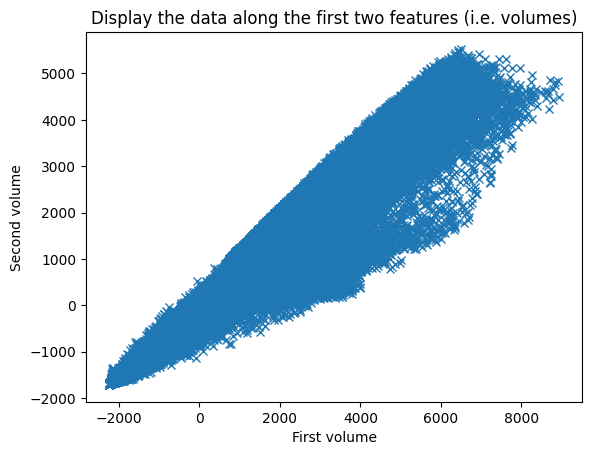

In [97]:
plt.plot(X[0], X[1], 'x')
plt.xlabel("First volume")
plt.ylabel("Second volume")
plt.title('Display the data along the first two features (i.e. volumes)')
plt.show()

### PCA 

In [100]:
# Compute the covariance matrix
covariance_matrix = np.cov(X)

# Get the U, S, VT matrices
U, S, VT = np.linalg.svd(covariance_matrix)

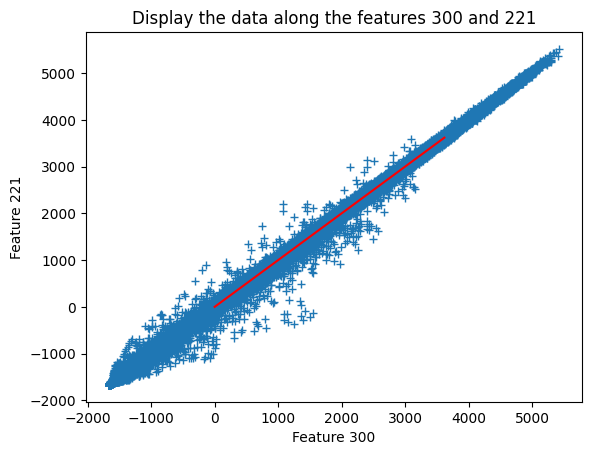

In [101]:
# Plot the signal in the first row against signal in the second row

# Choose which features to plot
feature1 = 300
feature2 = 221

plt.plot(X[feature1], X[feature2], '+')
scaled_u = U[:, 0] * -70000
plt.plot([0, scaled_u[feature1]], [0, scaled_u[feature2]], 'r')
plt.xlabel("Feature {}".format(feature1))
plt.ylabel("Feature {}".format(feature2))
plt.title('Display the data along the features {} and {}'.format(feature1, feature2))
plt.show()

In [103]:
# Scalar projection
C = U.T.dot(X)

C_vols = C.T.reshape(vol_shape + (n_vols,))

# Break 4D array in 3D
vol0 = C_vols[..., 0]
vol1 = C_vols[..., 1]

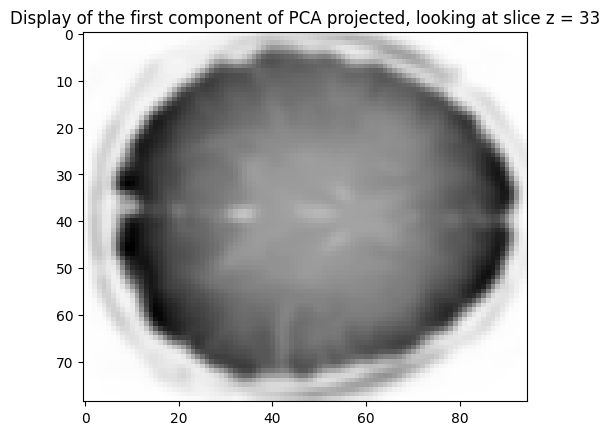

In [104]:
mid_z = int(vol0.shape[2]/2) - 1
plt.imshow(vol0[:, :, mid_z], cmap='gray')
plt.title("Display of the first component of PCA projected, looking at slice z = {}".format(mid_z))
plt.show()

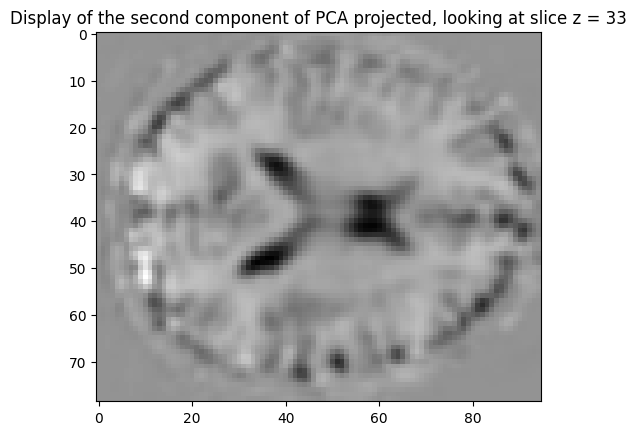

In [105]:
mid_z = int(vol1.shape[2]/2) - 1
plt.imshow(vol1[:, :, mid_z], cmap='gray')
plt.title("Display of the second component of PCA projected, looking at slice z = {}".format(mid_z))
plt.show()

### Spatial & Temporal ICA

Because we have only one stimulus lasting the whole experiment, it probably doesn't make any sense to look at the temporal ICA. (as it used to show when the brain is active or not basically)

### Group ICA

In [109]:
# Load first subject to use as basics for the next part
dataset_fmap = 'ds002322'
subject_fmap = ('18','22','35')

current_directory = os.getcwd()
individual = '18'
img = nib.load(current_directory + '/sub_'+individual +'/derivative/sub-'+individual+'_task-alice_bold_preprocessed.nii.gz')

In [131]:
#find x,y,z shapes on functional data of first subject
affine = img.affine
print("Shape of image ", img.shape, "\n")
x,y,z,vol = img.shape

# Remove the first volumes of each subject to avoid false correlation
discarded_data = 5

N_vol = 372
N_subj = 3
N_tot = (N_vol-discarded_data)* N_subj

X = np.zeros((N_tot, x*y*z))
i = 0
n_nii = 0
nb_subj_counted = 0
for n_nii in range(N_subj):
    print('Loading subject ', n_nii+1)
    img = nib.load(current_directory + '/sub_'+subject_fmap[n_nii] +'/derivative/sub-'+subject_fmap[n_nii]+'_task-alice_bold_preprocessed.nii.gz')
    data = np.asanyarray(img.dataobj)
    for j in range(N_vol-discarded_data):
        X[i] = data[:, :, :, j+discarded_data].reshape(x*y*z)
        i += 1
        
print("\n" + "Number of used vol ", int(X.shape[0]/N_subj))

print("\n" + "Finished loading ✅")

X = zscore(X, axis=1)
X = np.nan_to_num(X,0)


Shape of image  (79, 95, 68, 372) 

Loading subject  1
Loading subject  2
Loading subject  3

Number of used vol  367

Finished loading ✅


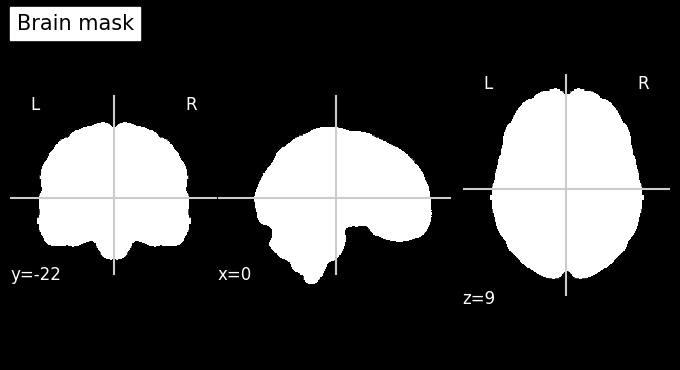

In [177]:
icbms = datasets.fetch_icbm152_2009()
masker = NiftiMasker(mask_img=icbms.mask)
plot_stat_map(icbms.mask, title='Brain mask',black_bg=True, colorbar=False)

In [187]:
S_dict = {}
n_components = [10, 20, 40]

for i in n_components:
    
    n2=2*i
    print('Running PCA with n = %d components 💁‍♂️'%n2)
    pca = PCA(n_components=n2)
    H = pca.fit_transform(X.T)
    print('Running FastICA with n = %d components 🏃'%i)

    ica = FastICA(n_components=i,random_state=1)
    S_ = ica.fit_transform(H)

    S_dict[i]=S_
    print('Done ✌️')

Running PCA with n = 20 components 💁‍♂️
Running FastICA with n = 10 components 🏃


c:\Users\Neizo\anaconda3\envs\DLAV\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Done ✌️
Running PCA with n = 40 components 💁‍♂️
Running FastICA with n = 20 components 🏃


c:\Users\Neizo\anaconda3\envs\DLAV\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Done ✌️
Running PCA with n = 80 components 💁‍♂️
Running FastICA with n = 40 components 🏃


c:\Users\Neizo\anaconda3\envs\DLAV\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Done ✌️


In [190]:
# Loading T1 image as a background
T1_img = icbms.t1 

Plotting for n = 10 components


c:\Users\Neizo\anaconda3\envs\DLAV\lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
c:\Users\Neizo\anaconda3\envs\DLAV\lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Plotting for n = 20 components


c:\Users\Neizo\anaconda3\envs\DLAV\lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
c:\Users\Neizo\anaconda3\envs\DLAV\lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Plotting for n = 40 components


c:\Users\Neizo\anaconda3\envs\DLAV\lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
c:\Users\Neizo\anaconda3\envs\DLAV\lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


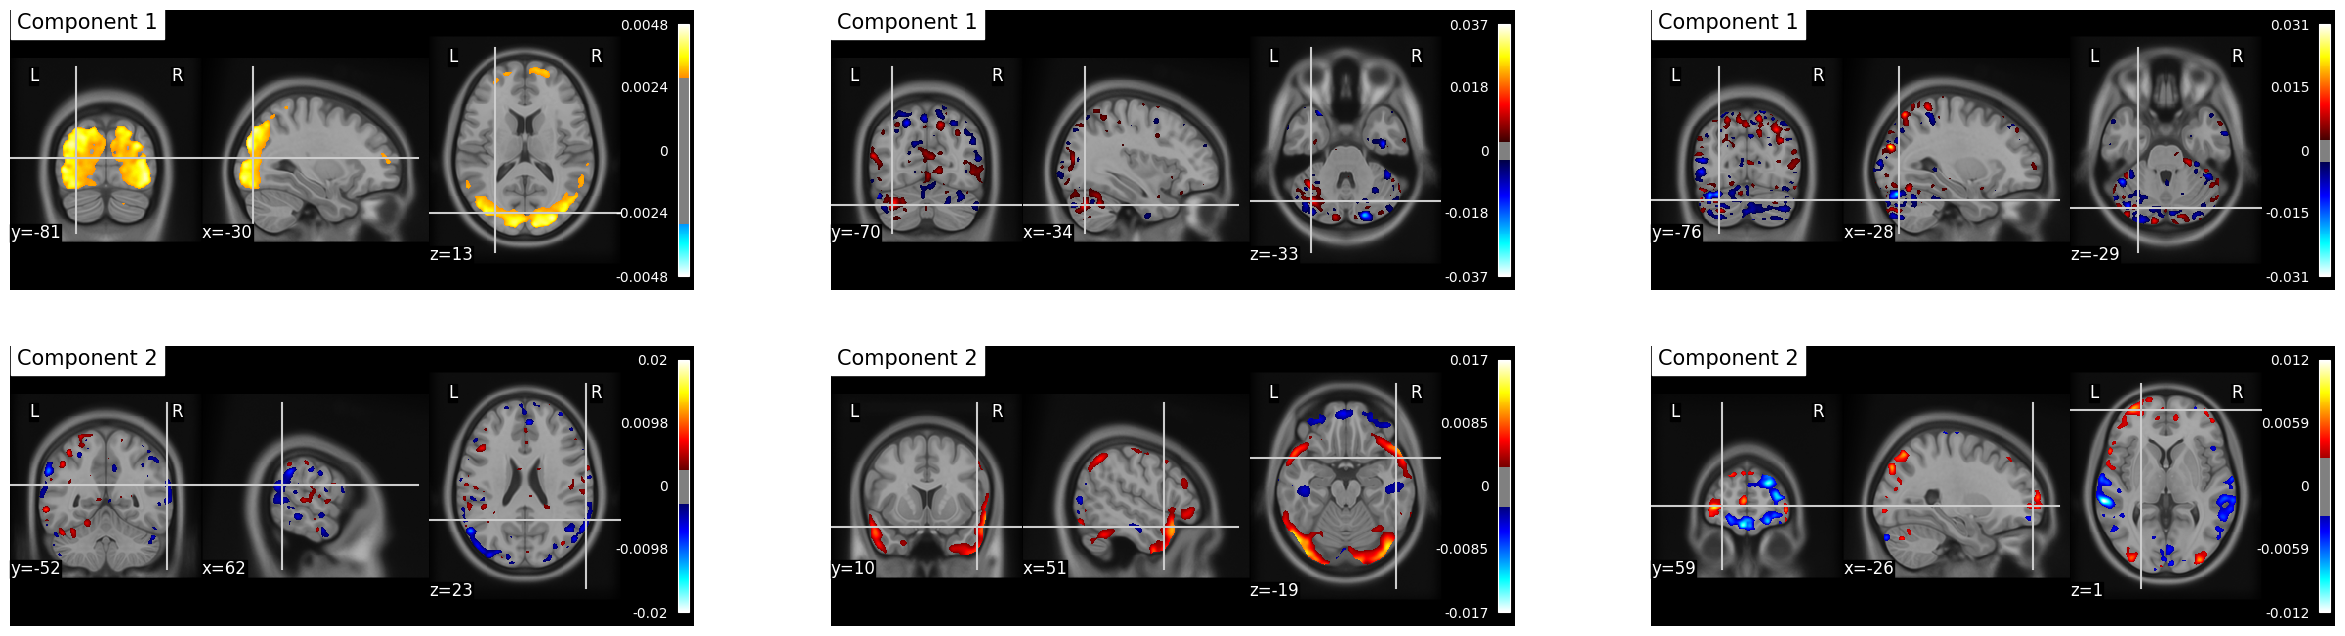

In [207]:
# Plot the ground level components for the different number of components, limited to the first 5 components
n_row = 2
fig, axes = plt.subplots(nrows = n_row, ncols = 3,figsize=(30, 8)) 
# gs = gridspec.GridSpec(n_row, 3, width_ratios=[1, 1, 1])

for j, i in enumerate(n_components):
    print('Plotting for n = %d components'%i)
    S_ = S_dict[i].copy()
    for idx, s in enumerate(S_.T[:(min(n_row, S_.T.shape[0]))]):
        s_img = nib.Nifti1Image(s.reshape(x,y,z), affine)
        data = masker.fit_transform(s_img)
        masked = masker.inverse_transform(data)
        plot_stat_map(masked, title='Component %d'%(idx+1),black_bg=True, colorbar=True, bg_img=T1_img, display_mode='ortho', threshold=2*np.std(s), axes=axes[idx, j])

# Seed analysis

In [77]:
# Get data from the first subject
current_directory = os.getcwd()
individual = '18'
img = nib.load(current_directory + '/sub_'+individual +'/derivative/sub-'+individual+'_task-alice_bold_preprocessed.nii.gz')
data = np.asanyarray(img.dataobj)

# Remove first 5 volumes because they are some weird artifacts
data = data[..., 5:]

print(data.shape)

(79, 95, 68, 372)


In [ ]:
# Choose one voxel
voxel_x = 20
voxel_y = 17
voxel_z = 30
voxel_time_series = data[voxel_x, voxel_y, voxel_z, :]

plt.plot(voxel_time_series)
plt.xlabel("Volume number")
plt.ylabel("Signal intensity")
plt.title("Time series for voxel ({}, {}, {})".format(voxel_x, voxel_y, voxel_z))
plt.show()

In [80]:
pearson_coeffs = np.zeros(data.shape[:-1])

# Go through all the voxels and compute the Pearson correlation coefficient
for x in range(data.shape[0]):
    for y in range(data.shape[1]):
        for z in range(data.shape[2]):
            pearson_coeffs[x, y, z] = np.corrcoef(voxel_time_series, data[x, y, z, :])[0, 1]

c:\Users\Neizo\anaconda3\envs\DLAV\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Neizo\anaconda3\envs\DLAV\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


c:\Users\Neizo\anaconda3\envs\DLAV\lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
c:\Users\Neizo\anaconda3\envs\DLAV\lib\site-packages\nilearn\image\resampling.py:663: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(


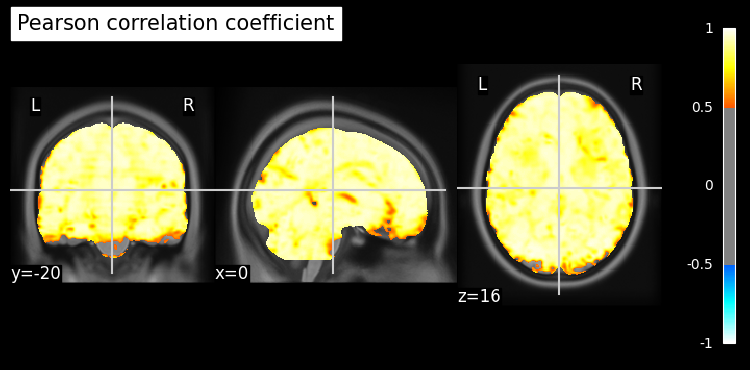

In [81]:
s_img = nib.Nifti1Image(pearson_coeffs, affine)
data_to_show = masker.fit_transform(s_img)
masked = masker.inverse_transform(data_to_show)
plot_stat_map(masked, title='Pearson correlation coefficient',black_bg=True, colorbar=True, bg_img=T1_img, display_mode='ortho', threshold=0.5)

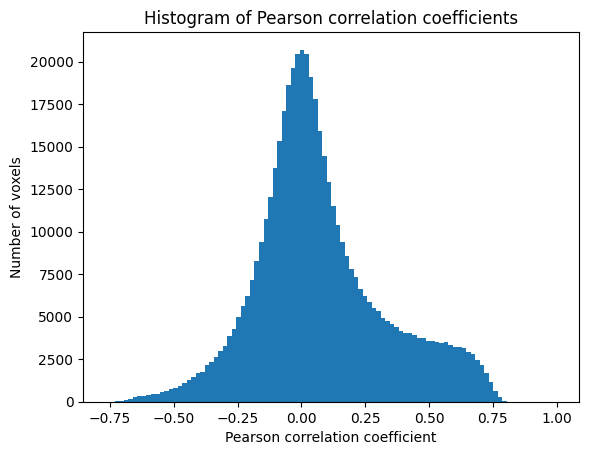

In [39]:
# Plot the histogram of the Pearson correlation coefficients
plt.hist(pearson_coeffs, bins=100)
plt.xlabel("Pearson correlation coefficient")
plt.ylabel("Number of voxels")
plt.title("Histogram of Pearson correlation coefficients")
plt.show()